# Chapter 4: Generative Adversarial Networks

## Generative Adversarial Network

A _generative adversarial network_  (GAN) is a pair of ANNs, a _generator_ and a _discriminator_. The generator creates new samples from random noise and the. discriminator tries to guess if a sample is real or fake. The generator is trained to trick the discriminator, allowing it to create more convincing new data than a VAE alone. Thsi concept was introduced by Ian Goodfellow in his tutorial, ["Generative Adversarial Networks"](https://channel9.msdn.com/Events/Neural-Information-Processing-Systems-Conference/Neural-Information-Processing-Systems-Conference-NIPS-2016/Generative-Adversarial-Networks).

Below is an example implementation of a GAN trained to generate images that look like they were sampled from [Google's Quick, Draw! dataset](https://pantheon.corp.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap?pli=1).

### Implementing a GAN

In [0]:
!pip install -U tensorflow-gpu

In [0]:
# Mount Google drive to load the data and to save the model weights.
# You can download the full_numpy_bitmap_camel.npy at the Quick, Draw!
# link above.
from google.colab import drive

drive.mount('/content/gdrive/')
drive_path_prefix = '/content/gdrive/My Drive/gdl_models/'
checkpoint_path = drive_path_prefix + 'gan/'

In [0]:
# Define a class which implements the model.

from tensorflow.keras.layers import (Input, Conv2D, LeakyReLU, Activation,
                                     Flatten, Dense, Reshape, UpSampling2D,
                                     Conv2DTranspose, Dropout,
                                     BatchNormalization)
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np


def get_activation(activation_fn_name):
  """Get the activation layer from the name of the function."""
  if activation_fn_name == 'leaky_relu':
    return LeakyReLU(alpha=0.2)
  return Activation(activation_fn_name)


def get_optimizer(optimizer_name, learning_rate):
  """Get an optimizer by name."""
  if optimizer_name == 'adam':
    return Adam(lr=learning_rate)
  if optimizer_name == 'rmsprop':
    return RMSprop(lr=learning_rate)
  return Adam(lr=learning_rate)


def set_trainable(model, value):
  """Set each layer of a model as trainable."""
  model.trainable = value
  for l in model.layers:
    l.trainable = value


class GAN(object):
  """Implements a GAN using Keras."""

  def __init__(self, input_shape, discriminator_conv_filters,
               discriminator_conv_kernel_size, discriminator_conv_strides,
               discriminator_batch_norm_momentum, discriminator_activation,
               discriminator_dropout_rate, discriminator_learning_rate,
               generator_initial_dense_layer_size, generator_upsample,
               generator_conv_filters, generator_conv_kernel_size,
               generator_conv_strides, generator_batch_norm_momentum,
               generator_activation, generator_dropout_rate,
               generator_learning_rate, optimizer, z_dim):
    discriminator_input = Input(shape=input_shape, name='discriminator_input')
    x = discriminator_input
    weight_init = RandomNormal(mean=0.0, stddev=0.02)
    for i in range(len(discriminator_conv_kernel_size)):
      x = Conv2D(filters=discriminator_conv_filters[i],
                 kernel_size=discriminator_conv_kernel_size[i],
                 strides=discriminator_conv_strides[i], padding='same',
                 name='discriminator_conv_{}'.format(i),
                 kernel_initializer=weight_init)(x)
      if discriminator_batch_norm_momentum and i > 0:
        x = BatchNormalization(momentum=discriminator_batch_norm_momentum)(x)
      x = get_activation(discriminator_activation)(x)
      if discriminator_dropout_rate:
        x = Dropout(rate=discriminator_dropout_rate)(x)
    x = Flatten()(x)
    discriminator_output = Dense(1, activation='sigmoid',
                                 kernel_initializer=weight_init)(x)
    self.discriminator = Model(discriminator_input, discriminator_output)
    self.discriminator_learning_rate = discriminator_learning_rate

    self.z_dim = z_dim

    generator_input = Input(shape=(z_dim,), name='generator_input')
    x = generator_input
    x = Dense(np.prod(generator_initial_dense_layer_size),
              kernel_initializer=weight_init)(x)
    if generator_batch_norm_momentum:
      x = BatchNormalization(momentum=generator_batch_norm_momentum)(x)
    x = get_activation(generator_activation)(x)
    x = Reshape(generator_initial_dense_layer_size)(x)
    if generator_dropout_rate:
      x = Dropout(generator_dropout_rate)(x)
    for i in range(len(generator_conv_filters)):
      if generator_upsample[i] == 2:
        x = UpSampling2D()(x)
        x = Conv2D(filters=generator_conv_filters[i],
                   kernel_size=generator_conv_kernel_size[i],
                   padding='same', name='generator_conv_{}'.format(i),
                   kernel_initializer=weight_init)(x)
      else:
        x = Conv2DTranspose(filters=generator_conv_filters[i],
                            kernel_size=generator_conv_kernel_size[i],
                            padding='same', strides=generator_conv_strides[i],
                            name='generator_conv_{}'.format(i),
                            kernel_initializer=weight_init)(x)
      if i < len(generator_conv_filters) - 1:
        if generator_batch_norm_momentum:
          x = BatchNormalization(momentum=generator_batch_norm_momentum)(x)
        x = get_activation(generator_activation)(x)
      else:
        x = Activation('tanh')(x)
    generator_output = x
    self.generator = Model(generator_input, generator_output)

    self.discriminator.compile(
        optimizer=get_optimizer(optimizer, discriminator_learning_rate),
        loss='binary_crossentropy', metrics=['accuracy'])
    
    set_trainable(self.discriminator, False)

    model_input = Input(shape=(z_dim,), name='model_input')
    model_output = self.discriminator(self.generator(model_input))
    self.model = Model(model_input, model_output)

    self.model.compile(
        optimizer=get_optimizer(optimizer, generator_learning_rate),
        loss='binary_crossentropy', metrics=['accuracy'])

    set_trainable(self.discriminator, True)
  
  def train_discriminator(self, X_train, batch_size):
    """Train the discriminator to discern between real and fake images."""
    idx = np.random.randint(0, len(X_train), size=batch_size)
    X_real = X_train[idx]
    
    noise = np.random.normal(loc=0.0, scale=1.0, size=(batch_size, self.z_dim))
    X_fake = self.generator.predict(noise)

    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))

    d_loss_real, d_acc_real = self.discriminator.train_on_batch(X_real, y_real)
    d_loss_fake, d_acc_fake = self.discriminator.train_on_batch(X_fake, y_fake)
    d_loss = (d_loss_real + d_loss_fake) / 2.0
    d_acc = (d_acc_real + d_acc_fake) / 2.0
    return (d_loss, d_acc)

  def train_generator(self, batch_size):
    """Train the generator to create fake images that can trick the discriminator."""
    noise = np.random.normal(0, 1, size=(batch_size, self.z_dim))
    valid = np.ones((batch_size, 1))
    return self.model.train_on_batch(noise, valid)

  def train(self, X_train, batch_size, epochs, print_every_n_epochs=10,
            initial_epoch=0, checkpoint_path=None, save_every_n_epochs=10,
            epochs_before_starting_generator=0):
    """Train the GAN model."""
    if initial_epoch > 0 and checkpoint_path:
      self.model.load_weights(
          checkpoint_path + 'model_weights_{:03d}.hdf5'.format(initial_epoch))
    for epoch in range(initial_epoch + 1, epochs + 1):
      d_loss, d_acc = self.train_discriminator(X_train, batch_size)
      if epoch > epochs_before_starting_generator:
        g_loss, g_acc = self.train_generator(batch_size)
      if epoch % print_every_n_epochs == 0:
        print('Epoch: {}'.format(epoch))
        print('D Loss: {:04f} D Accuracy: {:04f}'.format(d_loss, d_acc))
        if epoch > epochs_before_starting_generator:
          print('G Loss: {:04f} G Accuracy: {:04f}'.format(g_loss, g_acc))
      if epoch % save_every_n_epochs == 0 and checkpoint_path:
        print('Saving after epoch: {}'.format(epoch))
        self.model.save_weights(checkpoint_path + 'model_weights.hdf5')
        self.model.save_weights(
            checkpoint_path + 'model_weights_{}.hdf5'.format(epoch))

In [0]:
gan = GAN(input_shape=(28, 28, 1),
          discriminator_conv_filters=(64, 64, 128, 128),
          discriminator_conv_kernel_size=(5, 5, 5, 5),
          discriminator_conv_strides=(2, 2, 2, 1),
          discriminator_batch_norm_momentum=None,
          discriminator_activation='leaky_relu',
          discriminator_dropout_rate=0.4,
          discriminator_learning_rate=0.001,
          generator_initial_dense_layer_size=(7, 7, 64),
          generator_upsample=(2, 2, 1, 1),
          generator_conv_filters=(128, 64, 64, 1),
          generator_conv_kernel_size=(5, 5, 5, 5),
          generator_conv_strides=(1, 1, 1, 1),
          generator_batch_norm_momentum=0.9,
          generator_activation='relu',
          generator_dropout_rate=None,
          generator_learning_rate=0.0004,
          optimizer='rmsprop', z_dim=100)

In [0]:
gan.discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 7, 7, 64)          102464    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0     

In [0]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 14, 14, 128)       2049

### Downloading the Data

In [0]:
data_path = drive_path_prefix + 'data/full_numpy_bitmap_camel.npy'
data = np.load(data_path)

In [0]:
X_train = data.reshape((data.shape[0], 28, 28, 1)) / 255.0

In [0]:
X_train.shape

(121399, 28, 28, 1)

## Training the GAN

Below we train the GAN, training a GAN can be difficult for many reasons:

- _Mode collapse_ is when the generator learns to make samples that trick the discriminator but do not look like convincing samples. This could be because the generator model is too complex or the discriminator fails to learn the features of the training set.

- _Oscillating loss_ is when the discriminator or generator's loss begins to diverge and oscillate wildly, instead of converging.

It is particularly tricky to train GANs because the loss of the generator is not necessarily informative about its performance.

In [0]:
gan.train(X_train, batch_size=64, epochs=12000, checkpoint_path=checkpoint_path,
          save_every_n_epochs=100, print_every_n_epochs=10, initial_epoch=11000)

## Analyzing the Results

Below are a plot of some of the original images in the Quick, Draw! dataset that we used to train the model. We see the drawings mostly have the same general structure.

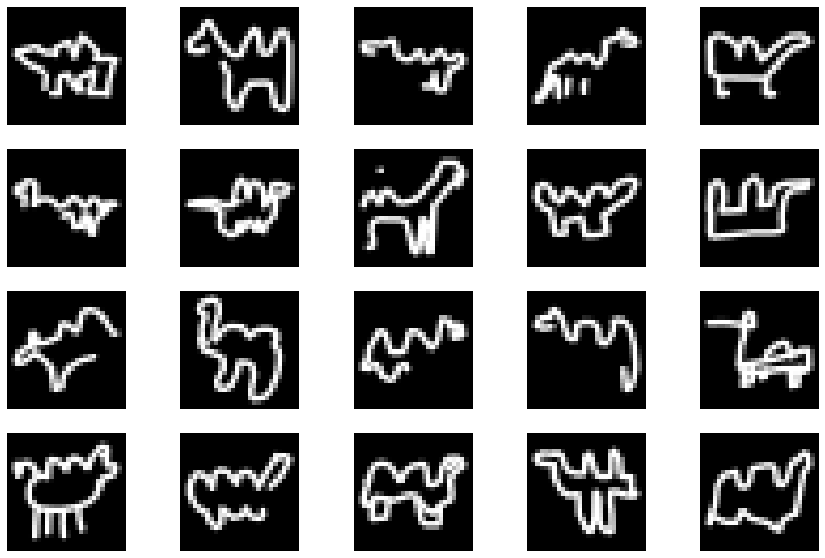

In [0]:
import matplotlib.pyplot as plt

n_to_show = 20
fig = plt.figure(figsize=(15, 10))

for i in range(n_to_show):
  ax = fig.add_subplot(4, n_to_show / 4, i + 1)
  ax.axis('off')
  idx = np.random.randint(0, len(X_train))
  ax.imshow(X_train[idx].squeeze(), cmap='gray')

Below are some of the model's generated "drawings" of camels. We see that the model was able to mostly learn the structure of the camel drawings we used to train the model.

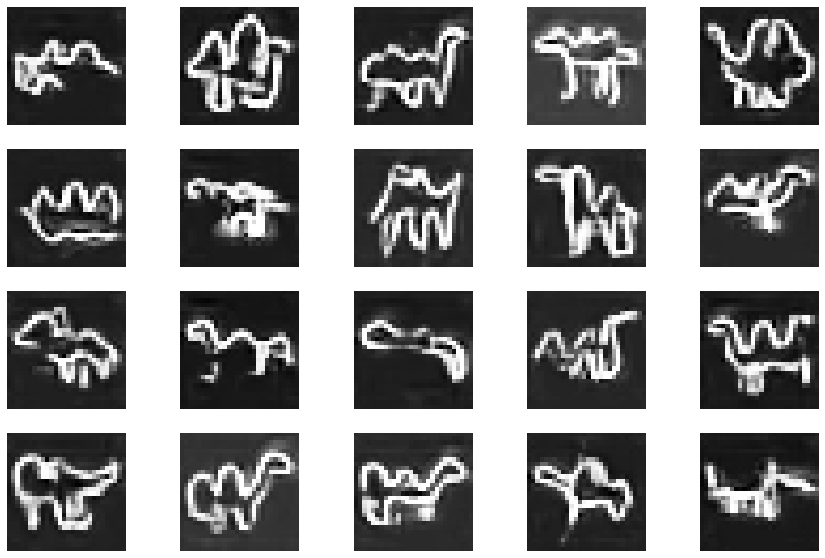

In [7]:
fig = plt.figure(figsize=(15, 10))

for i in range(n_to_show):
  ax = fig.add_subplot(4, n_to_show / 4,  i + 1)
  ax.axis('off')
  ax.imshow(
      gan.generator.predict(np.random.normal(size=(1,gan.z_dim))).squeeze(),
      cmap='gray')